# Let's see if it's working

In [1]:
import torch

import matplotlib.pyplot as plt

from nn.sequential import *
from nn.activation import *
from nn.linear import *
from nn.loss import *

In [2]:
def gen_data(n):
    x = torch.rand((2 * n, 2))
    pi = torch.acos(torch.zeros(1)).item() * 2
    target = ((x - torch.Tensor([0.5, 0.5])).pow(2).sum(dim=1) <= 1/(2*pi)) * 1

    x_train, x_test = x[:n], x[n:]
    y_train, y_test = target[:n], target[n:]
    return x_train, x_test, y_train.view(-1, 1), y_test.view(-1, 1)

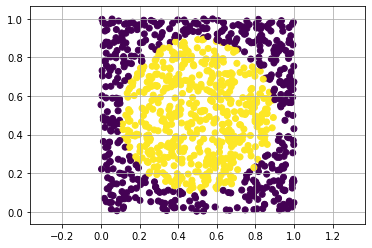

In [3]:
# Create test data
x_train, x_test, y_train, y_test = gen_data(1000)

# Plot test data
plt.scatter(x_train.numpy()[:,0], x_train.numpy()[:,1], c=y_train[:, 0])
plt.axis('equal')
plt.grid()
plt.show()

In [4]:
LinNet_ours = Sequential((
    Linear(2, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 25),
    ReLU(),
    Linear(25, 1)),
    MSELoss()
)

LinNet_theirs = torch.nn.Sequential(
    torch.nn.Linear(2, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 25),
    torch.nn.ReLU(),
    torch.nn.Linear(25, 1)
)
print(f'ours {LinNet_ours}, theirs {LinNet_theirs}')

print(Linear(25, 25))

ours Sequential(
	(0): Linear(in_features=2, out_features=25, bias=True)
	(1): ReLU()
	(2): Linear(in_features=25, out_features=25, bias=True)
	(3): ReLU()
	(4): Linear(in_features=25, out_features=25, bias=True)
	(5): ReLU()
	(6): Linear(in_features=25, out_features=1, bias=True)
), theirs Sequential(
  (0): Linear(in_features=2, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=25, bias=True)
  (5): ReLU()
  (6): Linear(in_features=25, out_features=1, bias=True)
)
Linear(in_features=25, out_features=25, bias=True)


In [5]:
# Iterate over samples in x
loss_fn_theirs = torch.nn.MSELoss()
optimizer_theirs = torch.optim.SGD(LinNet_theirs.parameters(), lr=0.01)
train_loss_ours = []
train_loss_theirs = []
n_epochs = 15
for e in range(n_epochs):
    for i in range(len(x_train)):
        # Get one data sample
        x_sample = x_train[i]
        y_sample = y_train[i].float()

        # Forward ours
        out_ours = LinNet_ours(x_sample)
        loss_ours = LinNet_ours.loss(out_ours, y_sample)
        train_loss_ours.append(loss_ours)
        #print(f'our ours: {out}')

        # Forward theirs
        out_theirs = LinNet_theirs(x_sample)
        loss_theirs = loss_fn_theirs(out_theirs, y_sample)
        train_loss_theirs.append(loss_theirs.item())
        #print(f'our theirs: {out}')

        # Backward ours
        LinNet_ours.backward()

        # Backward theirs
        optimizer_theirs.zero_grad()
        loss_theirs.backward()
        optimizer_theirs.step()

        # Update params
        LinNet_ours.update_params(optim='sgd', lr=0.01)
    print(f'finished epoch {e} with train loss: {sum(train_loss_ours)/len(train_loss_ours)} (ours), {sum(train_loss_theirs)/len(train_loss_theirs)} (theirs)')

finished epoch 0 with train loss: 0.25457245111465454 (ours), 0.2609056070768221 (theirs)
finished epoch 1 with train loss: 0.2513428032398224 (ours), 0.25255839048442164 (theirs)
finished epoch 2 with train loss: 0.24709543585777283 (ours), 0.2430050737365752 (theirs)
finished epoch 3 with train loss: 0.2382216900587082 (ours), 0.22569476321791151 (theirs)
finished epoch 4 with train loss: 0.2204175740480423 (ours), 0.20420984655080457 (theirs)
finished epoch 5 with train loss: 0.20133425295352936 (ours), 0.18644599492525374 (theirs)
finished epoch 6 with train loss: 0.18579161167144775 (ours), 0.17249676483914722 (theirs)
finished epoch 7 with train loss: 0.1732482761144638 (ours), 0.16119242225873023 (theirs)
finished epoch 8 with train loss: 0.162947878241539 (ours), 0.15197032131628682 (theirs)
finished epoch 9 with train loss: 0.15424679219722748 (ours), 0.14426442719238752 (theirs)
finished epoch 10 with train loss: 0.14678490161895752 (ours), 0.13773538972184987 (theirs)
finish